# Finding the 2D $Y$-$E_r$ Distributions Given Arvind's Yield Dist

Arvind has calculated 1-dimensional yield distributions for a given recoil energy, $E_r$. For some of the analysis of the NR Fano paper we would like to know the 2-dimensional distribution in the Yield-Recoil plane. I try to begin calculating that below, first for the $E_p$/$E_q$ plane. 

## The $Y$/$E_r$ Plane

Here, I'm jumping into the $Y$-$E_r$ plane instead.

In [1]:
import numpy as np

#construct the functions

#constants
V = 4.0
eps = 3.3/1000 #in keV/pair
#sigq = 1.0
#sigp = 1.0
F = 0.0

#Jardin resolutions
import resfuncRead as rfr

#read the files
ptres = rfr.getRFunc('data/jardin_ptres.txt')
qres = rfr.getRFunc('data/jardin_qsummaxres.txt')

#make the resolution functions
fp = rfr.makeRFunc(ptres[1]['sqrt'])
fq = rfr.makeRFunc(qres[1]['lin'],True)

sigp = lambda x: fp(x) #convert from eV
sigq = lambda x: fq(x) #convert from eV

print(sigp((1+(V/(eps*1000)))*100))
print(sigq(100))

#yield
a = 0.16
b = 0.18

ynr = lambda x: a*x**b
y = lambda x: 1



4.99303989675548
1.3062099999999999


In [2]:
#get Arvind's function
from prob_dist import ratio_dist_v2

#remember the signature: def ratio_dist_v2(x, Er, meanN, sdP, sdQ, sdN, V,e)

far = lambda Y,Er: ratio_dist_v2(Y,Er,Er*y(Er)/eps,sigp((1+(V/(eps*1000))*y(Er))*Er), \
                                 sigq(y(Er)*Er),np.sqrt(F*Er*y(Er)/eps),V/1000,eps)


print(far(0.7,10))

0.06386615272184269


In [3]:
#get the distribution in Er, use a simple exponential for now

alpha = 1/100 #that means will be down by a factor of e at 100 keV
alphaer = 1/1000 #the ER band is basically flat

per = lambda Er: alphaer*np.exp(-alphaer*Er)
pnr = lambda Er: alpha*np.exp(-alpha*Er)

In [4]:
pj = lambda Er,Y: far(Y,Er)*per(Er)

print(pj(10,0.7))

6.323067388445933e-05


In [5]:
#let's try to get a look at a contour plot
xg = np.linspace(0, 100, 100)
yg = np.linspace(0.7, 1.2, 100)

X, Y = np.meshgrid(xg, yg)
pj_v = np.vectorize(pj)
Z = pj_v(X,Y)

In [6]:
#test out the plotting 
#set up a plot 
import matplotlib as mpl
from matplotlib import pyplot as plt
#got smarter about the mpl config: see mplstyles/ directory
plt.style.use('standard')

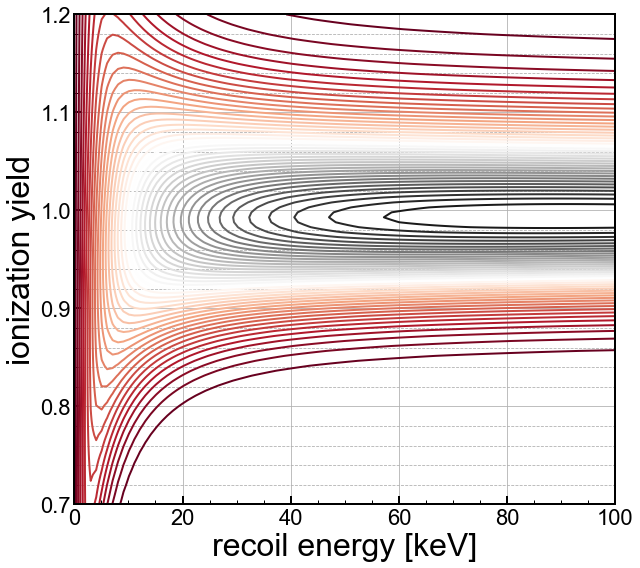

In [7]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes



#plot quick
#fig = plt.figure()
#ax1 = fig.add_subplot(111)
#ax1.plot(x, ingrndv_alt(x),label='E$_r$ function')
#ax1.contour(X, Y, Z, colors='black',label='E$_r$/N')
ax1.contour(X, Y, Z, 50,cmap='RdGy');


ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.set_xlim(0, 100) 
ax1.set_ylim(0.7,1.2)
ax1.set_xlabel('recoil energy [keV]',**axis_font)
ax1.set_ylabel('ionization yield',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
#ax1.legend(loc=2,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
plt.savefig('figures/2D_analytical_Band_ER.png')
plt.show()

In [8]:
#now do NRs

F=50.0
print(ynr(100))

far_nr = lambda Y,Er: ratio_dist_v2(Y,Er,Er*ynr(Er)/eps,sigp((1+(V/(eps*1000))*ynr(Er))*Er), \
                                 sigq(ynr(Er)*Er),np.sqrt(F*Er*ynr(Er)/eps),V/1000,eps)

pjnr = lambda Er,Y: far_nr(Y,Er)*pnr(Er)

print(pjnr(10,0.2))

0.3665388244428437
0.038914871162591104


In [9]:
#let's try to get a look at a contour plot
xgnr = np.linspace(0, 100, 300)
ygnr = np.linspace(0.0, 0.7, 300)

Xnr, Ynr = np.meshgrid(xgnr, ygnr)
pjnr_v = np.vectorize(pjnr)
Znr = pjnr_v(Xnr,Ynr)

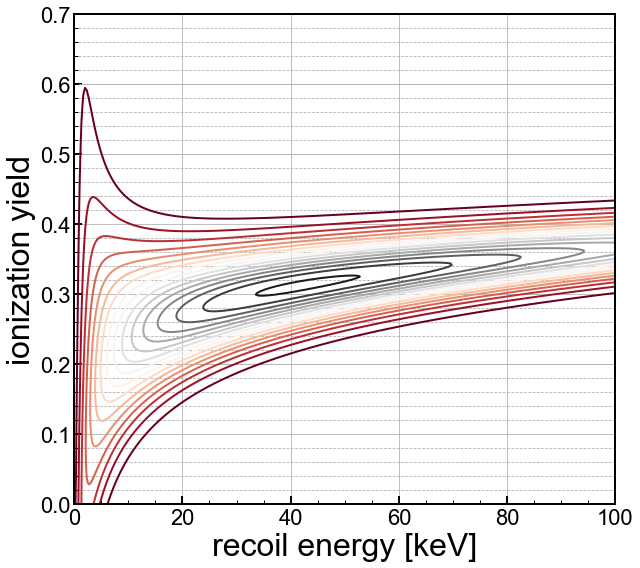

In [10]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes



#plot quick
#fig = plt.figure()
#ax1 = fig.add_subplot(111)
#ax1.plot(x, ingrndv_alt(x),label='E$_r$ function')
#ax1.contour(X, Y, Z, colors='black',label='E$_r$/N')
ax1.contour(Xnr, Ynr, Znr, 20,cmap='RdGy');


ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.set_xlim(0, 100) 
ax1.set_ylim(0.0,0.7)
ax1.set_xlabel('recoil energy [keV]',**axis_font)
ax1.set_ylabel('ionization yield',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
#ax1.legend(loc=2,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
plt.savefig('figures/2D_analytical_Band_NR.png')
plt.show()

## Taking into Account the Measured $E_r$

Actually, I think the above analysis is flawed, see N-MISC-19-001, pg 23. We should take into account the joint distribution with the _measured_ $E_r$. 

In [27]:
F=1.0
Eqbar = lambda Er: ynr(Er)*Er
Eqsig = lambda Er: np.sqrt(sigq(Er)**2 + F*ynr(Er)*Er) #assumes sigq contains no Fano contrib
Epsig = lambda Er: np.sqrt(sigp(Er)**2 + (V/1000)**2*(1/eps)*F*ynr(Er)*Er) #assumes sigp contains no Fano contrib
Etrsig = lambda Er: np.sqrt(Epsig(Er)**2 + ((V/eps)**2*Eqsig(Er)**2))

Y_ErMeas = lambda Y,Etr,Er: (1/np.sqrt(2*np.pi*Eqsig(Er)))*Etr*np.exp(-(Etr*Y-Eqbar(Er))**2/(2*Eqsig(Er)**2)) \
  *(1/np.sqrt(2*np.pi*Etrsig(Er)))*np.exp(-(Etr-Er)**2/(2*Etrsig(Er)**2))

print(Eqbar(10))
print(Eqsig(10))
print(Epsig(10))
print(sigq(10))
print(sigp(10))
print(Y_ErMeas(0.25,11,10))

2.421697997497933
1.6333860691503228
0.4666511191552184
0.4962379
0.45389613455100386
0.03017021299302281
